In [ ]:
!pip install roboflow
!pip install ultralytics  # YOLOv9 might be part of ultralytics package

from roboflow import Roboflow
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import yaml
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 16.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KMnKzp2xY8Y9XZKQj5tx")
project = rf.workspace("yasai").project("yasai-ninshiki")
version = project.version(7)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Yasai-Ninshiki-7 in yolov8:: 100%|██████████| 18062/18062 [00:02<00:00, 7686.96it/s]


In [ ]:
# Define paths to your training, validation, and test sets
train_images_path = "/content/Yasai-Ninshiki-7/train/images"
train_labels_path = "/content/Yasai-Ninshiki-7/train/labels"
val_images_path = "/content/Yasai-Ninshiki-7/valid/images"
val_labels_path = "/content/Yasai-Ninshiki-7/valid/labels"
test_images_path = "/content/Yasai-Ninshiki-7/test/images"
test_labels_path = "/content/Yasai-Ninshiki-7/test/labels"

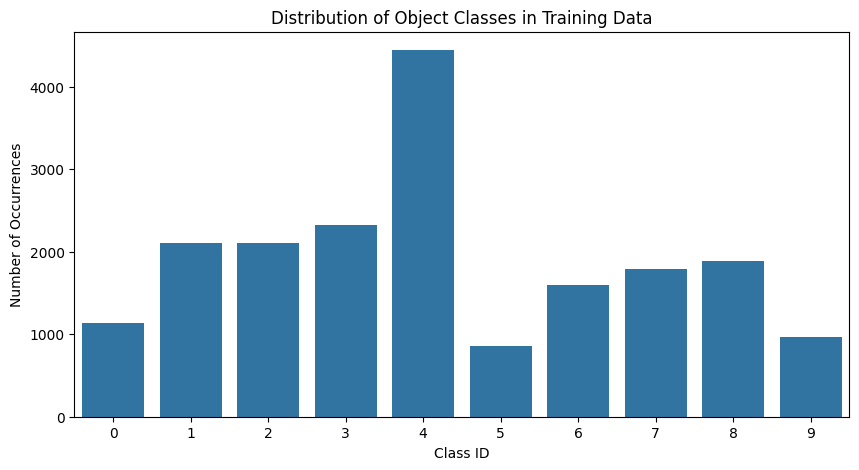

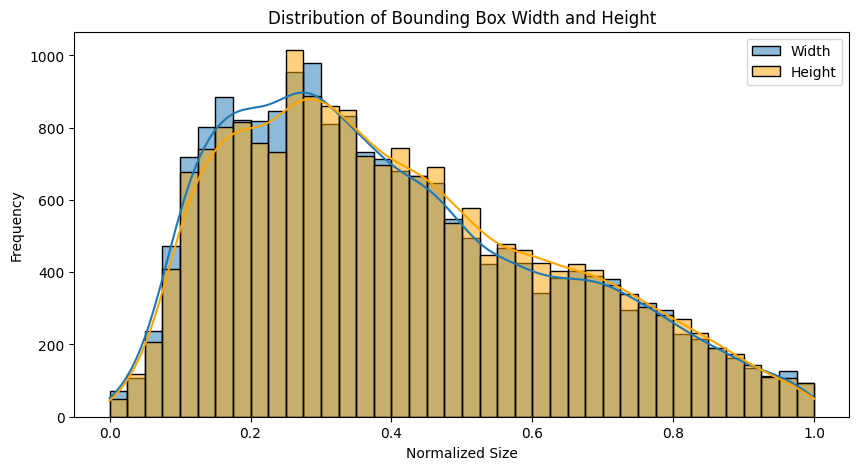

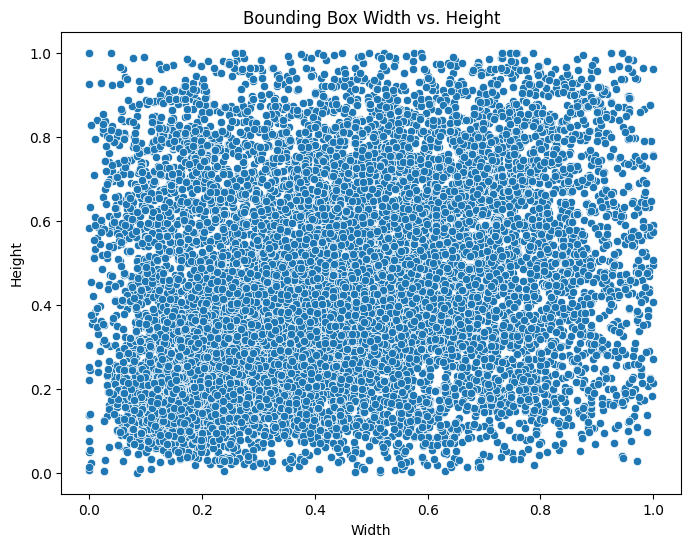

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def parse_yolo_label(label_file):
    """Parses a YOLO label file and returns a list of bounding box information.
    Handles lines with extra values by truncating or skipping them.
    """
    with open(label_file, 'r') as f:
        lines = f.readlines()
    bboxes = []
    for line in lines:
        values = line.strip().split()
        if len(values) >= 5:  # Check if there are enough values
            # Truncate to 5 values if there are more
            class_id, x_center, y_center, width, height = map(float, values[:5])
            bboxes.append({
                'class_id': int(class_id),
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })
        else:
            print(f"Warning: Skipping line with insufficient values in {label_file}: {line.strip()}")
    return bboxes

# Create empty lists to store label information
image_filenames = []
class_ids = []
bbox_widths = []
bbox_heights = []

# Loop through the training label files
for filename in os.listdir(train_labels_path):
  if filename.endswith(".txt"):
    label_file = os.path.join(train_labels_path, filename)
    bboxes = parse_yolo_label(label_file)
    for bbox in bboxes:
      image_filenames.append(filename.replace(".txt", ".jpg"))  # Assuming image files are .jpg
      class_ids.append(bbox['class_id'])
      bbox_widths.append(bbox['width'])
      bbox_heights.append(bbox['height'])

# Create a DataFrame for analysis
label_df = pd.DataFrame({
    'image_filename': image_filenames,
    'class_id': class_ids,
    'bbox_width': bbox_widths,
    'bbox_height': bbox_heights
})


# 1. Class Distribution
class_counts = label_df['class_id'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Object Classes in Training Data')
plt.xlabel('Class ID')
plt.ylabel('Number of Occurrences')
plt.show()

# 2. Bounding Box Size Analysis
plt.figure(figsize=(10, 5))
sns.histplot(label_df['bbox_width'], kde=True, label='Width')
sns.histplot(label_df['bbox_height'], kde=True, label='Height', color='orange')
plt.title('Distribution of Bounding Box Width and Height')
plt.xlabel('Normalized Size')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 3. Relationship between Bounding Box Width and Height (Optional)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='bbox_width', y='bbox_height', data=label_df)
plt.title('Bounding Box Width vs. Height')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

In [ ]:
def create_dataframe_from_labels(label_directory, label_names):
    data = {'image_file': [], 'class_id': [], 'x_center': [], 'y_center': [], 'width': [], 'height': []}
    for filename in os.listdir(label_directory):
        if filename.endswith(".txt"):
            image_file = filename.replace(".txt", ".jpg")  # Assuming images are JPG
            with open(os.path.join(label_directory, filename), "r") as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])

                    data['image_file'].append(image_file)
                    data['class_id'].append(class_id)
                    data['x_center'].append(x_center)
                    data['y_center'].append(y_center)
                    data['width'].append(width)
                    data['height'].append(height)

    df = pd.DataFrame(data)
    if label_names:
        df['class_name'] = df['class_id'].map(lambda x: label_names[x] if x < len(label_names) else 'Unknown')
    return df

# Create DataFrame for analysis
df = create_dataframe_from_labels(train_labels_path, None)

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler # Import StandardScaler

def create_dataframe_from_labels(label_directory, label_names):
    data = {'image_file': [], 'class_id': [], 'x_center': [], 'y_center': [], 'width': [], 'height': []}
    for filename in os.listdir(label_directory):
        if filename.endswith(".txt"):
            image_file = filename.replace(".txt", ".jpg")  # Assuming images are JPG
            with open(os.path.join(label_directory, filename), "r") as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])

                    data['image_file'].append(image_file)
                    data['class_id'].append(class_id)
                    data['x_center'].append(x_center)
                    data['y_center'].append(y_center)
                    data['width'].append(width)
                    data['height'].append(height)

    df = pd.DataFrame(data)
    if label_names:
        df['class_name'] = df['class_id'].map(lambda x: label_names[x] if x < len(label_names) else 'Unknown')
    return df

# Create DataFrames for analysis for train, validation and test sets
train_df = create_dataframe_from_labels(train_labels_path, None) # Assign to train_df
val_df = create_dataframe_from_labels(val_labels_path, None) # Assign to val_df
test_df = create_dataframe_from_labels(test_labels_path, None) # Assign to test_df

# Apply preprocessing (scaling, etc.) to training, validation, and test DataFrames
scaler = StandardScaler()

# Preprocess train data
train_df[['x_center', 'y_center', 'width', 'height']] = scaler.fit_transform(
    train_df[['x_center', 'y_center', 'width', 'height']]
)

# Preprocess validation data using the same scaler
val_df[['x_center', 'y_center', 'width', 'height']] = scaler.transform(
    val_df[['x_center', 'y_center', 'width', 'height']]
)

# Preprocess test data using the same scaler
test_df[['x_center', 'y_center', 'width', 'height']] = scaler.transform(
    test_df[['x_center', 'y_center', 'width', 'height']]
)

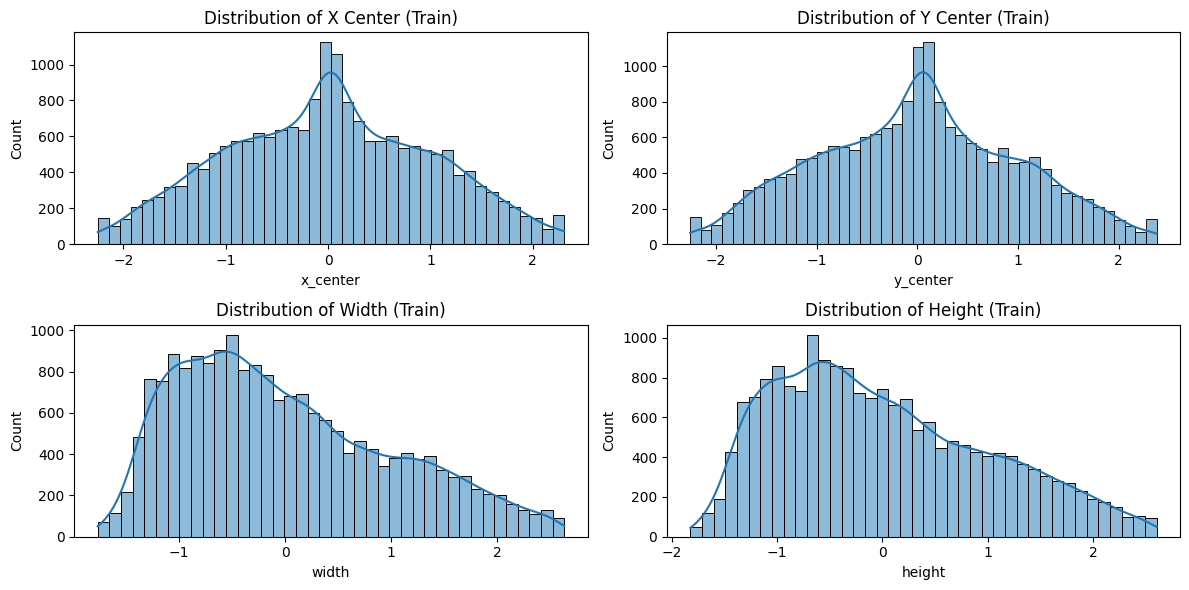

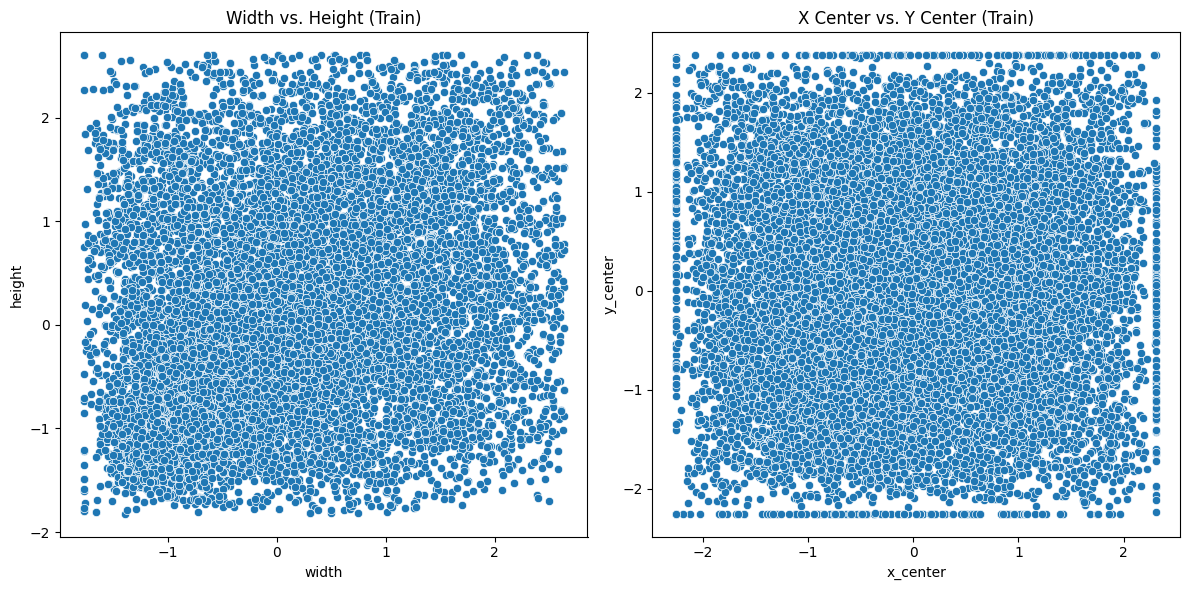

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Visualize preprocessed data for training set
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(train_df['x_center'], kde=True)
plt.title('Distribution of X Center (Train)')

plt.subplot(2, 2, 2)
sns.histplot(train_df['y_center'], kde=True)
plt.title('Distribution of Y Center (Train)')

plt.subplot(2, 2, 3)
sns.histplot(train_df['width'], kde=True)
plt.title('Distribution of Width (Train)')

plt.subplot(2, 2, 4)
sns.histplot(train_df['height'], kde=True)
plt.title('Distribution of Height (Train)')
plt.tight_layout()
plt.show()

# Scatter plots to visualize relationships between variables in the training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='width', y='height', data=train_df)
plt.title('Width vs. Height (Train)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='x_center', y='y_center', data=train_df)
plt.title('X Center vs. Y Center (Train)')
plt.tight_layout()
plt.show()


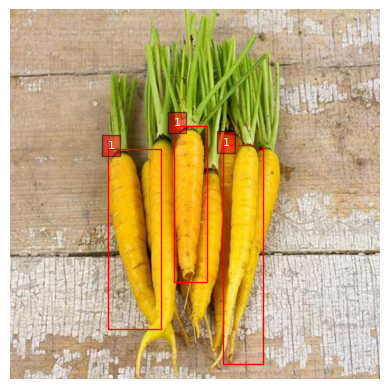

Error processing image: /content/Yasai-Ninshiki-7/train/images/234_jpg.rf.da5f0fd35d2aa697c4da4cb757837ed0.jpg, too many values to unpack (expected 5)
Error processing image: /content/Yasai-Ninshiki-7/train/images/n145_jpg.rf.7b487bdd8404723f11f4e1e6815c151b.jpg, too many values to unpack (expected 5)
Error processing image: /content/Yasai-Ninshiki-7/train/images/fresh-raw-japanese-purple-eggplants-in-a-basket-P65WT0_jpg.rf.b5953ee7139e8a7c09e1818b9e4a5fb2.jpg, too many values to unpack (expected 5)


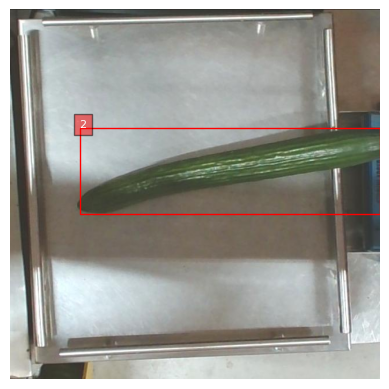

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

def plot_image_with_labels(image_path, label_path, class_names=None):
  """
  Plots an image with bounding boxes and labels.

  Args:
    image_path: Path to the image file.
    label_path: Path to the corresponding label file.
    class_names: A list of class names for mapping class IDs to labels.
  """

  try:
    img = Image.open(image_path)
    plt.imshow(img)
    ax = plt.gca()

    with open(label_path, 'r') as f:
      for line in f:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        x_center = x_center * img.width
        y_center = y_center * img.height
        width = width * img.width
        height = height * img.height

        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        if class_names:
          label = class_names.get(int(class_id), 'Unknown')
        else:
          label = str(int(class_id))

        plt.text(x_min, y_min, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

  except Exception as e:
    print(f"Error processing image: {image_path}, {e}")



for filename in os.listdir(train_labels_path)[:5]:  # Process only the first 5 images
    if filename.endswith(".txt"):
        image_file = filename.replace(".txt", ".jpg")
        image_path = os.path.join(train_images_path, image_file)
        label_path = os.path.join(train_labels_path, filename)
        plot_image_with_labels(image_path, label_path)


In [ ]:
import os

def get_labels_from_directory(directory):
  """
  Gets a list of unique labels from a directory of YOLO label files.

  Args:
    directory: Path to the directory containing label files.

  Returns:
    A list of unique labels found in the files.
  """
  labels = set()
  for filename in os.listdir(directory):
    if filename.endswith(".txt"):
      with open(os.path.join(directory, filename), "r") as f:
        for line in f:
          label_id = int(line.split()[0])
          labels.add(label_id)
  return list(labels)


def get_label_names_from_dataset(dataset_path):
  """
  Attempts to get label names from the dataset's data.yaml file (Roboflow).

  Args:
    dataset_path: Path to the dataset directory.

  Returns:
    A list of label names (strings) or None if not found.
  """
  data_yaml_path = os.path.join(dataset_path, "data.yaml")
  if os.path.exists(data_yaml_path):
    with open(data_yaml_path, "r") as f:
      import yaml
      try:
        data = yaml.safe_load(f)
        return data.get("names", [])
      except yaml.YAMLError as exc:
        print(exc)
  return None


label_directory = "/content/Yasai-Ninshiki-7/test/labels"
label_ids = get_labels_from_directory(label_directory)
print("Found label IDs:", label_ids)

dataset_path = "/content/Yasai-Ninshiki-7"
label_names = get_label_names_from_dataset(dataset_path)
if label_names:
  print("Label Names:", label_names)
else:
  print("Could not find label names in data.yaml.")

Found label IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Label Names: ['Broccoli', 'Carrot', 'Cucumber', 'Eggplant', 'Garlic', 'Green pepper', 'Onion', 'Paprika', 'Potato', 'Tomato']


In [ ]:
!pip install ultralytics --upgrade

In [ ]:
from ultralytics import YOLO
import os
import yaml

# Load the YOLOv8 model
model = YOLO('yolov8x')

# Get label names from the dataset
def get_label_names_from_dataset(dataset_path):
    """
    Attempts to get label names from the dataset's data.yaml file (Roboflow).

    Args:
        dataset_path: Path to the dataset directory.

    Returns:
        A list of label names (strings) or None if not found.
    """
    data_yaml_path = os.path.join(dataset_path, "data.yaml")
    if os.path.exists(data_yaml_path):
        with open(data_yaml_path, "r") as f:
            try:
                data = yaml.safe_load(f)
                return data.get("names", [])
            except yaml.YAMLError as exc:
                print(exc)
    return None

dataset_path = "/content/Yasai-Ninshiki-7"  # Update with your actual dataset path
label_names = get_label_names_from_dataset(dataset_path)

if label_names:
    print("Label Names:", label_names)
else:
    print("Could not find label names in data.yaml. Please check the file.")
    exit()  # Exit if label names are not found

# Paths to train, validation, and test images (update these paths)
train_images_path = "/content/Yasai-Ninshiki-7/test/images"
val_images_path = "/content/Yasai-Ninshiki-7/valid/images"
test_images_path = "/content/Yasai-Ninshiki-7/test/images"

# Create a data.yaml file only if it doesn't exist
data_yaml_path = 'data.yaml'
if not os.path.exists(data_yaml_path):
    data_yaml = {
        'train': train_images_path,
        'val': val_images_path,
        'test': test_images_path,
        'nc': len(label_names),  # Number of classes based on label names
        'names': label_names  # Use the label names from the dataset
    }

    with open(data_yaml_path, 'w') as f:
        yaml.dump(data_yaml, f)
    print(f"Created data.yaml at {data_yaml_path}")
else:
    print(f"Using existing data.yaml at {data_yaml_path}")

# Train the model, referencing the data.yaml file
model.train(
    data=data_yaml_path,  # Path to your data.yaml file
    epochs=12,
    batch=52,
    imgsz=640,
    project='yolo_v8_fruits_veg',
    amp=True,  # Mixed precision training
)

# Evaluate the model
metrics = model.val()
print(metrics)

# Test the model on the test set
results = model.predict(source=test_images_path, save=True)

# Save the trained model as a .pt file
model_path = "trained_yolov8x_model.pt"
model.save(model_path)
print(f"Model saved as {model_path}")

100%|██████████| 131M/131M [00:00<00:00, 188MB/s]


Label Names: ['Broccoli', 'Carrot', 'Cucumber', 'Eggplant', 'Garlic', 'Green pepper', 'Onion', 'Paprika', 'Potato', 'Tomato']
Created data.yaml at data.yaml
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=12, time=None, patience=100, batch=52, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolo_v8_fruits_veg, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, clas

100%|██████████| 755k/755k [00:00<00:00, 14.0MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 62.3MB/s]


AMP: checks passed ✅


train: Scanning /content/Yasai-Ninshiki-7/test/labels... 365 images, 0 backgrounds, 0 corrupt: 100%|██████████| 365/365 [00:00<00:00, 1117.02it/s]

train: New cache created: /content/Yasai-Ninshiki-7/test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 325, len(boxes) = 1085. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/Yasai-Ninshiki-7/valid/labels... 743 images, 0 backgrounds, 0 corrupt: 100%|██████████| 743/743 [00:00<00:00, 860.95it/s]

val: New cache created: /content/Yasai-Ninshiki-7/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 671, len(boxes) = 1886. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to yolo_v8_fruits_veg/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.00040625000000000004), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_v8_fruits_veg/train
Starting training for 12 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/12      39.3G      1.005      4.066      1.481          2        640: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.45s/it]

                   all        743       1886      0.416      0.147      0.102     0.0818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/12        39G      1.127      2.729      1.593          2        640: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


                   all        743       1886        0.4      0.442      0.347      0.272
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/12        39G     0.8139      2.185      1.231          1        640: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:10<00:00,  1.36s/it]

                   all        743       1886      0.399      0.412      0.274      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/12        39G     0.8555      1.852      1.336          2        640: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


                   all        743       1886       0.23      0.449      0.143     0.0946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/12      38.9G     0.9153      2.119      1.307          3        640: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


                   all        743       1886       0.38      0.241      0.134     0.0821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/12      38.9G     0.9095      1.929      1.297          5        640: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


                   all        743       1886     0.0617       0.26     0.0413     0.0231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/12      38.9G     0.9712        1.8      1.429          2        640: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


                   all        743       1886      0.288       0.37      0.196      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/12        39G      1.065      1.967      1.632          1        640: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


                   all        743       1886      0.505      0.299      0.221       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/12        39G     0.9117      1.561      1.333          3        640: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


                   all        743       1886      0.732      0.247      0.307      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/12        39G     0.8853      1.602      1.298          2        640: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


                   all        743       1886      0.596      0.459      0.467      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/12        39G     0.7584      1.363      1.186          1        640: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


                   all        743       1886      0.552      0.572      0.556       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/12        39G     0.7067      1.141      1.124          5        640: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        743       1886      0.701      0.544      0.602      0.464



12 epochs completed in 0.048 hours.
Optimizer stripped from yolo_v8_fruits_veg/train/weights/last.pt, 136.7MB
Optimizer stripped from yolo_v8_fruits_veg/train/weights/best.pt, 136.7MB

Validating yolo_v8_fruits_veg/train/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 268 layers, 68,133,198 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


                   all        743       1886      0.701      0.545      0.602      0.464
              Broccoli         81        102      0.816      0.892      0.925      0.792
                Carrot         66        155      0.671      0.387      0.466      0.319
              Cucumber         27         38          1          0     0.0222     0.0123
              Eggplant        101        211      0.442       0.54      0.484      0.301
                Garlic         38        146      0.518      0.664      0.631      0.467
          Green pepper         29         54      0.941      0.588      0.815      0.738
                 Onion        120        215      0.569      0.419      0.503      0.329
               Paprika         44        115      0.547      0.745       0.76      0.621
                Potato        223        796      0.664       0.73      0.721      0.541
                Tomato         37         54      0.839      0.481      0.689      0.514
Speed: 0.1ms preproce

val: Scanning /content/Yasai-Ninshiki-7/valid/labels.cache... 743 images, 0 backgrounds, 0 corrupt: 100%|██████████| 743/743 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 671, len(boxes) = 1886. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


                   all        743       1886        0.7      0.544      0.602      0.464
              Broccoli         81        102      0.817      0.892      0.926      0.786
                Carrot         66        155      0.673      0.387      0.467      0.322
              Cucumber         27         38          1          0     0.0222     0.0123
              Eggplant        101        211       0.44       0.54      0.484      0.303
                Garlic         38        146       0.52      0.664       0.63      0.468
          Green pepper         29         54      0.941      0.588      0.815      0.738
                 Onion        120        215      0.573      0.419      0.502      0.329
               Paprika         44        115      0.543      0.739       0.76      0.623
                Potato        223        796      0.666       0.73      0.721      0.543
                Tomato         37         54      0.824      0.481      0.689      0.513
Speed: 0.2ms preproce


image 1/1 /content/Yasai-Ninshiki-7/test/images/47_jpg.rf.8b1d40d754de48de0bb196a53cadafab.jpg: 640x640 5 Broccolis, 15.0ms
Speed: 2.1ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to yolo_v8_fruits_veg/train4


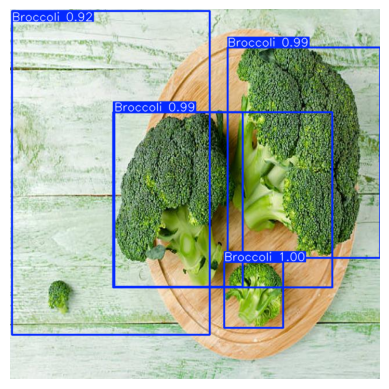

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Get a list of image files from the test set
test_image_files = [f for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.png'))]

# Select a random image from the test set
random_image_file = random.choice(test_image_files)
random_image_path = os.path.join(test_images_path, random_image_file)

# Run inference on the selected image
results = model.predict(source=random_image_path, save=True, conf=0.5)

# Display the image with predictions
for result in results:
  im_array = result.plot()  # Plot the image with bounding boxes
  im = Image.fromarray(im_array[..., ::-1])  # Convert to PIL image
  plt.imshow(im)
  plt.axis('off')  # Turn off axis labels
  plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Assuming you have already trained and validated your model

# Get a list of image files from the test set
test_image_files = [f for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.png'))]

# Select two or three random images from the test set
num_random_images = 10
random_image_files = random.sample(test_image_files, num_random_images)

for random_image_file in random_image_files:
  random_image_path = os.path.join(test_images_path, random_image_file)

  # Run inference on the selected image
  results = model.predict(source=random_image_path, save=True, conf=0.5)

  # Display the image with predictions
  for result in results:
    im_array = result.plot()  # Plot the image with bounding boxes
    im = Image.fromarray(im_array[..., ::-1])
    plt.imshow(im)
    plt.axis('off')  # Turn off axis labels
    plt.show()



image 1/1 /content/resized_image.jpg: 448x640 1 Broccoli, 1 Garlic, 2 Onions, 1 Paprika, 6 Tomatos, 15.8ms
Speed: 3.3ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)
Results saved to yolo_v8_fruits_veg/train17
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([9., 9., 6., 6., 4., 0., 9., 7., 9., 9., 9.], device='cuda:0')
conf: tensor([0.8951, 0.4966, 0.4737, 0.3323, 0.3283, 0.1185, 0.0973, 0.0959, 0.0658, 0.0649, 0.0570], device='cuda:0')
data: tensor([[8.2118e+02, 4.8522e+02, 1.0240e+03, 6.7514e+02, 8.9511e-01, 9.0000e+00],
        [5.2524e+02, 3.6650e+02, 6.9948e+02, 5.2205e+02, 4.9656e-01, 9.0000e+00],
        [1.0969e+02, 2.7259e+02, 7.0172e+02, 6.4597e+02, 4.7371e-01, 6.0000e+00],
        [2.7779e+02, 3.8768e+02, 5.8052e+02, 6.4479e+02, 3.3234e-01, 6.0000e+00],
        [1.1066e+02, 2.7277e+02, 6.8953e+02, 6.4732e+02, 3.2829e-01, 4.0000e+00],
        [6.0281e+02, 8.6855e+01, 1.1950e+03, 4.3184e+02, 1.1847e-01, 0.0000e+00],


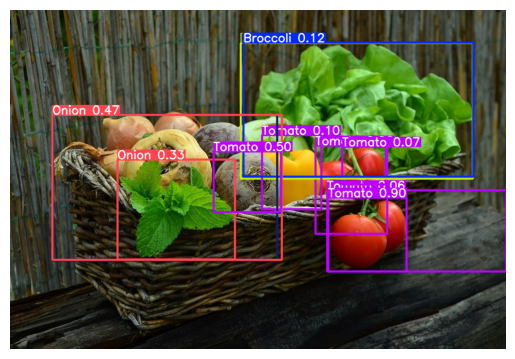

Detection results saved to detection_results.csv


In [ ]:
import csv
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO


# Specify the path of the image
image_path = '/content/drive/MyDrive/AIOT/vegetables-752153_1280.jpg'

# Open and resize the image to match its original dimensions for better accuracy
image = Image.open(image_path)
image = image.resize((1280, 875))  # Resize to original dimensions for better detection
image.save("resized_image.jpg")  # Save the resized image

# Create a CSV file to store the results
with open('detection_results.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Image File', 'Detected Class', 'Confidence'])  # Header row

    # Run inference on the resized image with a lower confidence threshold and adjusted NMS threshold
    results = model.predict(
        source="resized_image.jpg",
        save=True,
        conf=0.05,  # Lower confidence threshold for more detections
        iou=0.4  # Adjust Non-Maximum Suppression (NMS) threshold if needed
    )

    for result in results:
        boxes = result.boxes  # Boxes object for detected objects
        print(boxes)  # Print bounding box coordinates for diagnostics

        for box in boxes:
            # Get the class label and confidence
            class_id = int(box.cls[0].item())
            confidence = box.conf[0].item()

            # Map class ID to label name, handling out-of-range errors
            try:
                class_name = model.names[class_id]  # Use model.names to get labels
            except IndexError:
                class_name = 'unknown'

            # Write results to the CSV file, using the actual image path
            csv_writer.writerow([image_path, class_name, confidence])

        # Display the image with predictions at the specified confidence threshold
        im_array = result.plot(conf=0.05)  # Match conf to the inference threshold
        im = Image.fromarray(im_array[..., ::-1])
        plt.imshow(im)
        plt.axis('off')
        plt.show()

print("Detection results saved to detection_results.csv")

In [ ]:
import cv2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow  # For Colab display
from IPython.display import clear_output  # Import the necessary patch



# Open the video file
video_path = '/content/drive/MyDrive/AIOT/992683-hd_1920_1080_25fps.mp4'  # Replace with your video path
cap = cv2.VideoCapture(video_path)

frame_count=0
# Loop through the video frames
while cap.isOpened():
    success, frame = cap.read()

    if success:
        # Run YOLOv8 inference on the frame
        results = model(frame)

        # Annotate the frame with detected objects
        annotated_frame = results[0].plot()

        # Display the annotated frame using cv2_imshow
        cv2_imshow(annotated_frame)
        clear_output(wait=True)

        # Extract information about detected objects (class, bounding box, confidence)
        for result in results:
            boxes = result.boxes
            for box in boxes:
                class_id = box.cls[0].item()
                confidence = box.conf[0].item()
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                print(f"Class: {class_id}, Confidence: {confidence}, Bounding Box: ({x1}, {y1}, {x2}, {y2})")

        # Break the loop if 'q' is pressed
        # for example, break after processing 100 frames:
        frame_count += 1
        if frame_count >= 100:
            break
    else:
        break

# Release the video capture and destroy windows
cap.release()
cv2.destroyAllWindows()

In [ ]:
!export LC_ALL=C.UTF-8
!export LANG=C.UTF-8
!pip install openai==0.28


NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968